In [1]:
from datetime import date
from glob import glob
import io
import os
from PIL import Image
import sys
import json
import time

import gspread
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import signal
from pptx import Presentation
from pptx.util import Inches

In [2]:
sys.path.append(r'C:\Users\lesliec\code')

In [3]:
from tbd_eeg.tbd_eeg.data_analysis.eegutils import EEGexp

In [4]:
from tbd_eeg.tbd_eeg.data_analysis.Utilities.utilities import (
    find_nearest_ind, get_events_wdict, get_evoked_traces, qualitycheck_trials)

In [5]:
%matplotlib inline

## Functions

In [6]:
def get_good_bad_chs(bad_ch_str, ch_list):
    if bad_ch_str == 'all':
        bad_chs = ch_list
        good_chs = []
    else:
        badchstr = bad_ch_str.replace(' ','')
        bad_chs = []
        for char in badchstr.split(','):
            if char.isdecimal():
                bad_chs.append(int(char))
        good_chs = np.array([x for x in ch_list if x not in bad_chs])
    return good_chs, bad_chs

In [7]:
def get_pupil_data(pupil_file):
    pupildf = pd.read_csv(pupil_file)

    pupilts = pupildf.sync_time.values
    pupilD = pupildf.Largest_Radius.values
    eyeD = pupildf.Eye_Diameter.values

    ## Smooth pupil diameter ##
    smooth_pupil = np.zeros_like(pupilD)
    k = 15 # filter window is actually k*2+1
    for i in range(k, len(pupilD)-k-1):
        smooth_pupil[i] = np.mean(pupilD[i-k:i+k]) # each point is the average of k surrounding points
    smooth_pupil[:k] = pupilD[:k]
    smooth_pupil[-k-1:] = pupilD[-k-1:]
    
    normpupil = smooth_pupil / np.mean(eyeD)
    
    return normpupil, pupilts

In [8]:
def save_fig_to_pptx(fig, prs, slide=None, position=None):
    slide_W = 13; slide_H = 7
    set_dpi = 100

    # Save the Matplotlib figure to an in-memory buffer with tight bounding box
    image_buffer = io.BytesIO()
    fig.savefig(image_buffer, format='png', facecolor='white', dpi=set_dpi, bbox_inches='tight')#,pad_inches=0.1)
    image_buffer.seek(0)
    
    # Get figure size
    image = Image.open(image_buffer)
    width, height = image.size
    fig_W_inches = width / set_dpi
    fig_H_inches = height / set_dpi
    
    margin_pad = 0.1
    # Create new slide if none given
    # slide_layouts[5] is a title-only slide
    # slide_layouts[6] is a blank slide
    if slide is None:
        slide = prs.slides.add_slide(prs.slide_layouts[6])

    # Resize the figure if it's larger than the slide dimensions
    if fig_W_inches > slide_W or fig_H_inches > slide_H:
        # Calculate the scaling factor to fit within the slide
        scale_x = slide_W / fig_W_inches
        scale_y = slide_H / fig_H_inches

        # Use the smaller scaling factor to maintain the aspect ratio
        scale = min(scale_x, scale_y)

        # Set the new figure size
        fig.set_size_inches(fig_W_inches * scale, fig_H_inches * scale)
        fig_W_inches = fig.get_figwidth()
        fig_H_inches = fig.get_figheight()

    # Calculate the position and size to center the figure on the slide
    if position is None:
        left = (slide_W - fig_W_inches) / 2  # Center horizontally
        top = (slide_H - fig_H_inches) / 2  # Center vertically
    else:
        left = position[0]; top = position[1]

    # Convert to float point length (?)
    left = left * Inches(1)
    top = top * Inches(1)
    width = fig_W_inches * Inches(1)
    height = fig_H_inches * Inches(1)

    # Add the figure from the in-memory buffer to the slide
    pic = slide.shapes.add_picture(image_buffer, left, top, width, height)
    
    # Close the in-memory buffer
    image_buffer.close()
    image.close()

### Set save directory and metadata locations

In [9]:
plotsdir = r'C:\Users\lesliec\OneDrive - Allen Institute\data\plots\EEG_signal_quality'

In [10]:
_gc = gspread.service_account() # need a key file to access the account
## Load Templeton log ##
_sh = _gc.open('Templeton-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
Temp_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe
## Load Zap&zip log ##
_sh = _gc.open('Zap_Zip-log_exp') # open the spreadsheet
_df = pd.DataFrame(_sh.sheet1.get()) # load the first worksheet
ZZ_metadata = _df.T.set_index(0).T # put it in a nicely formatted dataframe

### Load subjects .csv

In [12]:
multisub_file = r"C:\Users\lesliec\OneDrive - Allen Institute\data\psilocybin_saline_subjects_2024_07.csv"
subject_df = pd.read_csv(multisub_file, converters={'mouse': str}).astype({'analyze_EEG': bool, 'analyze_NPX': bool})
subject_df.head()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
0,urethane,582386,urethane_2021-07-15_11-36-58,urethane,"0,2,3",True,True,10,NaN
1,urethane,638703,urethane_estim_2022-10-14_12-25-20,urethane,"0,3,4,6,7,11,13",True,True,25,NaN
2,urethane,654181,urethane_vis_2022-11-23_08-30-16,urethane,"7,8,11,13",True,True,25,NaN
3,saline,654182,estim_vis_2022-12-01_10-33-50,"awake,saline","3,6,14,22,23",True,True,25,NaN
4,urethane,654182,urethane_vis_2022-12-02_11-02-25,urethane,"3,6,14,22,23",True,True,25,NaN


In [13]:
subject_df.tail()

,exp_type,mouse,experiment,sweep_states,bad_chs,analyze_EEG,analyze_NPX,CCF_res,notes
74,ketanserin,730913,aw_ket_2024-04-26_10-11-34,"awake,ketanserin","0,3,13",False,True,25,EEG EPs are artifact for second sweep
75,saline,730911,aw_sal_2024-05-01_11-57-16,"awake,saline","3,23",True,True,25,NaN
76,ketanserin,730911,aw_ket_2024-05-02_10-41-41,"awake,ketanserin","3,9,10,11,20,23",True,True,25,"Strong, clean EPs for all currents"
77,saline,735049,aw_sal_2024-05-22_11-05-25,"awake,saline","3,12,29",True,True,25,NaN
78,ketanserin,735049,aw_ket_2024-05-23_11-42-08,"awake,ketanserin","3,12,29",True,True,25,"OK, but EP is smaller for second sweep"


# Test for single subject

In [13]:
subrow = subject_df.iloc[9]
print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))

666194 - psilocybin exp


Load experiment instance and EEG data

In [14]:
dfolder = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
exp_tag = exp.experiment_folder[exp.experiment_folder.find('mouse')+12:exp.experiment_folder.find(str(exp.date.year))-1]

Experiment type: electrical stimulation


In [15]:
eeg_data, eeg_ts = exp.load_eegdata()
eeg_chs = np.arange(0, eeg_data.shape[1])
print(exp.ephys_params['EEG']['sample_rate'])

2500


Find meta data from shared excel file

In [16]:
if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
    exp_meta = Temp_metadata[(
        (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & (Temp_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
    exp_meta = ZZ_metadata[(
        (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) & (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
    )].squeeze()
else:
    print('Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))

Get bad channels list from meta data

In [17]:
GOOD_CHS, bad_chs = get_good_bad_chs(subrow['bad_chs'], eeg_chs)

In [18]:
stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})

In [19]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial
0,biphasic,40,0.0004,1061.14291,1061.14331,0,True,0.000000,True
1,biphasic,40,0.0004,1064.75000,1064.75040,0,True,0.075932,False
2,biphasic,40,0.0004,1069.21232,1069.21272,0,True,0.113898,False
3,biphasic,40,0.0004,1072.71738,1072.71778,0,True,0.000000,True
4,biphasic,40,0.0004,1076.99273,1076.99313,0,True,7.441341,False


In [20]:
num_sweeps = len(np.unique(stim_log['sweep'].values))
num_estims = np.sum(stim_log['stim_type'].values == 'biphasic')
num_currents = len(np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values))

Get injection times, if they exist.

In [21]:
if subrow.exp_type in ['psilocybin', 'ketanserin', 'saline']:
    try:
        inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        print(inj_times)
    except:
        inj_times = None
        print(' No injection times for this {} experiment.'.format(subrow.exp_type))
elif subrow.exp_type == 'isoflurane':
    iso_hi, iso_level = exp.load_iso_times()
    inj_times = list(iso_hi)
else:
    inj_times = None
    print(' No injection times for this {} experiment.'.format(subrow.exp_type))

[197.21, 763.06]


Mask the estim artifact

In [22]:
mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
    val = find_nearest_ind(eeg_ts, etime) - 2
    eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]

Load running

In [23]:
running_file = os.path.join(exp.data_folder, 'running_signal.npy')
running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')

if os.path.exists(running_file) and os.path.exists(running_ts_file):
    speed = np.load(running_file)
    speedts = np.load(running_ts_file)

Load pupil

In [24]:
if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
    normpupil, pupilts = get_pupil_data(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0])
else:
    print('No local Pupileye*.csv file. Check server.')
    normpupil = None

Voltage histogram

In [25]:
Vbins = np.linspace(-6400, 6400, num=100)
Vhist = np.zeros((len(Vbins)-1, len(eeg_chs)), dtype=int)
for chi in eeg_chs:
    Vhist[:,chi], vbini = np.histogram(eeg_data[:, chi], bins=Vbins)

Spectrogram

In [26]:
frex, Pxx = signal.welch(
    eeg_data[:int(600. * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 10 min
    exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
)

Plot whole recording

### Make the combo plot

In [27]:
## Change orientation and plot all eegs downsampled ##
plot_chs = eeg_chs
ds = 5
sep = 1000
frinds = frex < 200

figsum  = plt.figure(figsize=(13,7))
gs = figsum.add_gridspec(ncols=3, nrows=2, left=0.06, right=0.98, hspace=0.28, wspace=0.3, top=0.92, bottom=0.08)

axbeh = figsum.add_subplot(gs[0,:2])
axEEG = figsum.add_subplot(gs[:,2], sharex=axbeh)
axh = figsum.add_subplot(gs[1,1])
axsp = figsum.add_subplot(gs[1,0])

## Behavior plot ##
if inj_times is not None:
    if subrow.exp_type == 'isoflurane':
        axbeh.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
        axEEG.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
    else:
        for itime in inj_times:
            axbeh.axvline(itime/60, color='red', linestyle='dashed')
            axEEG.axvline(itime/60, color='red', linestyle='dashed')
axbeh.plot(speedts/60, speed, 'seagreen', alpha=0.8)
axbeh.set_ylabel('Speed (cm/s)', color='seagreen')
axbeh.tick_params(axis='y', labelcolor='seagreen')
axbeh.set_ylim([0, 100])
axbeh.set_xlabel('Time (min)')
axpup = axbeh.twinx()
if normpupil is not None:
    axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
    axpup.set_ylabel('Normalized pupil diameter', color='m')
    axpup.tick_params(axis='y', labelcolor='m')
axpup.set_ylim([0, 1])
for rboo, rcol in zip([True, False], ['orange', 'green']):
    stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
    axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)
    
## EEG plot ##
for ii, chi in enumerate(plot_chs):
    axEEG.plot(eeg_ts[::ds] / 60, eeg_data[::ds, chi] + (ii * sep), 'k', linewidth=0.8, alpha=0.5)

axEEG.set_xlim([eeg_ts[0] / 60, eeg_ts[-1] / 60])
axEEG.set_xlabel('Time (min)')
axEEG.set_ylabel('Voltage (uV)')
axEEG.set_yticks(np.arange(len(plot_chs)) * sep)
axEEG.set_yticklabels(plot_chs)
axEEG.set_ylim([-sep, (ii + 1) * sep])
    
## Histogram of raw EEG voltage values ##
hplot = axh.imshow(Vhist.T / eeg_data.shape[0], cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=0.0001)
axh.set_ylabel('EEG ch number\nright <-> left')
tt = np.arange(0, len(Vbins), 10)
axh.set_xticks(tt)
axh.set_xticklabels(np.round(Vbins[tt] / 1000).astype(int))
axh.set_xlabel('Voltage (mV)')
axh.set_title('Histogram of voltages')
cbar = figsum.colorbar(hplot, ax=axh)
cbar.ax.set_ylabel('Fraction of recording length')
for bchi in bad_chs:
    axh.annotate(str(bchi), color='r', xy=(0.3, 1-bchi/len(eeg_chs)), xycoords='axes fraction', va='top')

## Frequency spectra of all EEG chs ##
for chi in eeg_chs:
    if chi in bad_chs:
        linecol = 'r'
    else:
        linecol = 'gray'
    axsp.loglog(frex[frinds], Pxx[frinds, chi], color=linecol, linewidth=1, alpha=0.5)
if len(GOOD_CHS) > 0:
    axsp.loglog(frex[frinds], np.median(Pxx[:, GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
axsp.set_xlim([0.5, 200])
axsp.set_ylim([0.1, 5000])
axsp.set_xlabel('Frequency (Hz)')
axsp.set_ylabel('Power (mV^2/Hz)')
axsp.set_title('Spectra across first 10 minutes')
    
figsum.suptitle(
    'Mouse {}: {} ({:d} sweeps, {:d} total e-stims, {:d} currents)'.format(
        subrow.mouse, subrow.experiment, num_sweeps, num_estims, num_currents
    ))
plt.close(figsum)

### Get evoked potentials

In [28]:
plot_win = [-1.0, 1.0] # epoch time
all_event_times = stim_log.onset.values
all_EP_traces, event_ts = get_evoked_traces(
    eeg_data, eeg_ts, all_event_times, np.abs(plot_win[0]), plot_win[1], exp.ephys_params['EEG']['sample_rate']
)

In [29]:
stim_log['stimname'] = ['estim_'+y if x == 'biphasic' else 'visual_'+x for x, y in zip(stim_log['stim_type'].values, stim_log['parameter'].values)]
### Get state label for each sweep ###
all_sweeps = np.unique(stim_log['sweep'].values)
sweep_state_list = []
for char in subrow.sweep_states.split(','):
    sweep_state_list.append(char)
if len(sweep_state_list) == 1:
    sweep_state_list = sweep_state_list * len(all_sweeps)
stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
num_stimtypes = len(np.unique(stim_log['stimname'].values))

In [30]:
stim_log.head()

,stim_type,parameter,duration,onset,offset,sweep,good,mean_speed,resting_trial,stimname,state
0,biphasic,40,0.0004,1061.14291,1061.14331,0,True,0.000000,True,estim_40,psilocybin
1,biphasic,40,0.0004,1064.75000,1064.75040,0,True,0.075932,False,estim_40,psilocybin
2,biphasic,40,0.0004,1069.21232,1069.21272,0,True,0.113898,False,estim_40,psilocybin
3,biphasic,40,0.0004,1072.71738,1072.71778,0,True,0.000000,True,estim_40,psilocybin
4,biphasic,40,0.0004,1076.99273,1076.99313,0,True,7.441341,False,estim_40,psilocybin


In [31]:
print(np.unique(stim_log['stimname'].values))
print(np.unique(stim_log['sweep'].values))

['estim_40']
[0 1 2 3 4 5 6 7 8 9]


Plot all events and sweeps

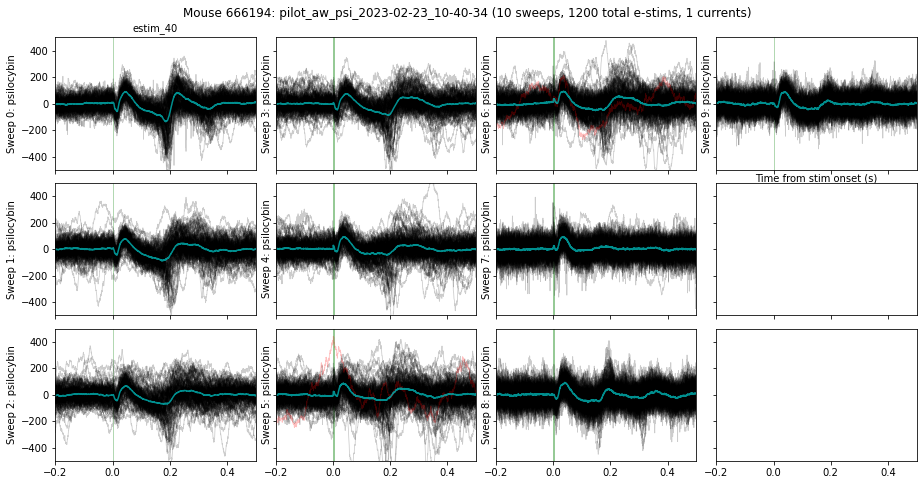

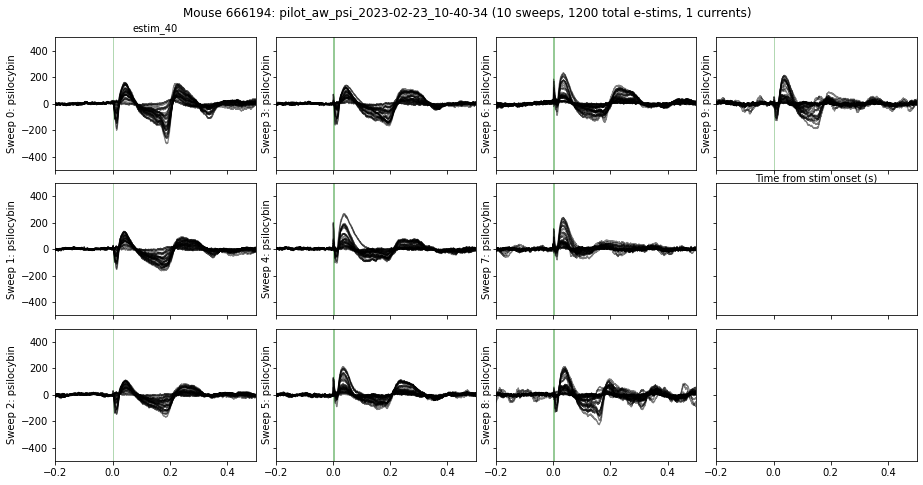

In [32]:
fig1 = plt.figure(figsize=(13,7))
fig2 = plt.figure(figsize=(13,7))

if num_stimtypes == 1:
    if num_sweeps > 3:
        plot_traces = all_EP_traces

        gs1 = fig1.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        axs = gs1[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')
        
        gs2 = fig2.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        bxs = gs2[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')

        for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
            for sweepi in np.unique(stim_log['sweep'].values):
                if sweepi > len(axs) - 1:
                    break
                eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
                event_inds = eventdf.index.values
                good_events = eventdf.good.values
                rest_events = eventdf.resting_trial.values
                event_state = eventdf.state.values[0]

                event_traces = plot_traces[:, :, event_inds]
                if len(GOOD_CHS) == 0:
                    all_trials = np.mean(event_traces, axis=1)
                else:
                    all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                mean_trials = np.mean(event_traces, axis=2)

                ## Plotting all trials ##
                axs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                axs[sweepi].plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
                if np.sum(good_events) < all_trials.shape[1]:
                    axs[sweepi].plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
                axs[sweepi].plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)

                ## Plotting all chs ##
                bxs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                if len(GOOD_CHS) == 0:
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                elif len(GOOD_CHS) < mean_trials.shape[1]:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                else:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)

                axs[sweepi].set_ylim([-500, 500])
                bxs[sweepi].set_ylim([-500, 500])
                if sweepi == 0:
                    axs[sweepi].set_title(stimi)
                    bxs[sweepi].set_title(stimi)
                if coli == 0:
                    axs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                    bxs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                else:
                    axs[sweepi].set_yticklabels([])
                    bxs[sweepi].set_yticklabels([])

            axs[sweepi].set_xlim([-0.2, 0.5])
            axs[sweepi].set_xlabel('Time from stim onset (s)')
            bxs[sweepi].set_xlim([-0.2, 0.5])
            bxs[sweepi].set_xlabel('Time from stim onset (s)')

        fig1.suptitle(
            f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
        fig2.suptitle(
            f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')

In [55]:
plot_traces = all_EP_traces

fig1 = plt.figure(figsize=(13,7))
gs1 = fig1.add_gridspec(
    nrows=1, ncols=len(np.unique(stim_log['stimname'].values)),
    left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08
)

fig2 = plt.figure(figsize=(13,7))
gs2 = fig2.add_gridspec(
    nrows=1, ncols=len(np.unique(stim_log['stimname'].values)),
    left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08
)

for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
    axs = gs1[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
    bxs = gs2[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
    for ax, bx, sweepi in zip(axs, bxs, np.unique(stim_log['sweep'].values)):
        eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
        event_inds = eventdf.index.values
        good_events = eventdf.good.values
        rest_events = eventdf.resting_trial.values
        event_state = eventdf.state.values[0]

        event_traces = plot_traces[:, :, event_inds]
        if len(GOOD_CHS) == 0:
            all_trials = np.mean(event_traces, axis=1)
        else:
            all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
        mean_trials = np.mean(event_traces, axis=2)
        
        ## Plotting all trials ##
        ax.axvspan(0, 0.002, color='g', alpha=0.3)
        ax.plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
        if np.sum(good_events) < all_trials.shape[1]:
            ax.plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
        ax.plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)
            
        ## Plotting all chs ##
        bx.axvspan(0, 0.002, color='g', alpha=0.3)
        if len(GOOD_CHS) == 0:
            bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
        elif len(GOOD_CHS) < mean_trials.shape[1]:
            bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
            bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
        else:
            bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
        
        ax.set_ylim([-500, 500])
        bx.set_ylim([-500, 500])
        if sweepi == 0:
            ax.set_title(stimi)
            bx.set_title(stimi)
        if coli == 0:
            ax.set_ylabel(f'Sweep {sweepi}: {event_state}')
            bx.set_ylabel(f'Sweep {sweepi}: {event_state}')
        else:
            ax.set_yticklabels([])
            bx.set_yticklabels([])
        
    ax.set_xlim([-0.2, 0.5])
    ax.set_xlabel('Time from stim onset (s)')
    bx.set_xlim([-0.2, 0.5])
    bx.set_xlabel('Time from stim onset (s)')
    
fig1.suptitle(
    f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
fig2.suptitle(
    f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
# plt.close(fig1)
# plt.close(fig2)

Test with one event type

To plot rectified average over all trials: absolute value -> average across good chs

To plot average for all chs

### Save figures in ppt

https://python-pptx.readthedocs.io/en/latest/user/quickstart.html

In [56]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(13)
prs.slide_height = Inches(7)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'Characterization of EEG and EP signal quality'
slide.placeholders[1].text = 'Templeton experiments with estim\n{}'.format(date.today().strftime('%b %d, %Y'))

In [57]:
## Add current figures to ppt ##
save_fig_to_pptx(figsum, prs)
save_fig_to_pptx(fig1, prs)
save_fig_to_pptx(fig2, prs)

In [58]:
## Save the ppt ##
prs.save(os.path.join(plotsdir, 'test4_676727.pptx'))

In [59]:
del prs

# Loop through all subjects and add summary plots

In [14]:
## Plotting parameters ##
# plot_chs = eeg_chs # which chs to plot signal for
ds = 5 # downsample factor for EEG signal plot
sep = 1000 # uV separation for vertical plot
plotfreq = 200 # frequencies for spectral plot

epoch = [-1.0, 1.0] # epoch time
plot_win = [-0.2, 0.5]
EP_yaxlims = [-500, 500]

In [ ]:
## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(13)
prs.slide_height = Inches(7)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'Characterization of EEG and EP signal quality'
slide.placeholders[1].text = 'Templeton experiments with estim\n{}'.format(date.today().strftime('%b %d, %Y'))

for indi, subrow in subject_df.iterrows():
    print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))
    dfolder = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
    if np.sum([True for x in exp.experiment_data if 'recording' in x]) == 0:
        print('  NO EEG\n')
        continue
    eeg_data, eeg_ts = exp.load_eegdata()
    eeg_chs = np.arange(0, eeg_data.shape[1])
    
    if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
        exp_meta = Temp_metadata[(
            (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & 
            (Temp_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
        exp_meta = ZZ_metadata[(
            (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) &
            (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    else:
        print(' Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))
        
    GOOD_CHS, bad_chs = get_good_bad_chs(subrow['bad_chs'], eeg_chs) 
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    num_sweeps = len(np.unique(stim_log['sweep'].values))
    num_estims = np.sum(stim_log['stim_type'].values == 'biphasic')
    num_currents = len(np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values))
    
    if subrow.exp_type in ['psilocybin', 'ketanserin', 'saline']:
        try:
            inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        except:
            inj_times = None
            print(' No injection times for this {} experiment.'.format(subrow.exp_type))
    elif subrow.exp_type == 'isoflurane':
        iso_hi, iso_level = exp.load_iso_times()
        inj_times = list(iso_hi)
    else:
        inj_times = None
        print(' No injection times for this {} experiment.'.format(subrow.exp_type))
        
    print('  Masking estim artifact...')
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]
        
    running_file = os.path.join(exp.data_folder, 'running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)
        
    print('  Getting pupil data...')
    if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
        normpupil, pupilts = get_pupil_data(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0])
    else:
        print(' No local Pupileye*.csv file. Check server.')
        normpupil = None
        
    Vbins = np.linspace(-6400, 6400, num=100)
    Vhist = np.zeros((len(Vbins)-1, len(eeg_chs)), dtype=int)
    for chi in eeg_chs:
        Vhist[:,chi], vbini = np.histogram(eeg_data[:, chi], bins=Vbins)
    frex, Pxx = signal.welch(
        eeg_data[:int(600. * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 10 min
        exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
    )
    print('  Making summary plot...')
    #### Summary plot ####
    figsum  = plt.figure(figsize=(13,7))
    gs = figsum.add_gridspec(ncols=3, nrows=2, left=0.06, right=0.98, hspace=0.28, wspace=0.3, top=0.92, bottom=0.08)
    axbeh = figsum.add_subplot(gs[0,:2])
    axEEG = figsum.add_subplot(gs[:,2], sharex=axbeh)
    axh = figsum.add_subplot(gs[1,1])
    axsp = figsum.add_subplot(gs[1,0])

    ## Behavior plot ##
    if inj_times is not None:
        if subrow.exp_type == 'isoflurane':
            axbeh.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
            axEEG.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
        else:
            for itime in inj_times:
                axbeh.axvline(itime/60, color='red', linestyle='dashed')
                axEEG.axvline(itime/60, color='red', linestyle='dashed')
    axbeh.plot(speedts/60, speed, 'seagreen', alpha=0.8)
    axbeh.set_ylabel('Speed (cm/s)', color='seagreen')
    axbeh.tick_params(axis='y', labelcolor='seagreen')
    axbeh.set_ylim([0, 100])
    axbeh.set_xlabel('Time (min)')
    axpup = axbeh.twinx()
    if normpupil is not None:
        axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
        axpup.set_ylabel('Normalized pupil diameter', color='m')
        axpup.tick_params(axis='y', labelcolor='m')
    axpup.set_ylim([0, 1])
    for rboo, rcol in zip([True, False], ['orange', 'green']):
        stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
        axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)

    ## EEG plot ##
    for ii, chi in enumerate(eeg_chs):
        axEEG.plot(eeg_ts[::ds] / 60, eeg_data[::ds, chi] + (ii * sep), 'k', linewidth=0.8, alpha=0.5)
    axEEG.set_xlim([eeg_ts[0] / 60, eeg_ts[-1] / 60])
    axEEG.set_xlabel('Time (min)')
    axEEG.set_ylabel('Voltage (uV)')
    axEEG.set_yticks(np.arange(len(eeg_chs)) * sep)
    axEEG.set_yticklabels(eeg_chs)
    axEEG.set_ylim([-sep, (ii + 1) * sep])

    ## Histogram of raw EEG voltage values ##
    hplot = axh.imshow(Vhist.T / eeg_data.shape[0], cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=0.0001)
    axh.set_ylabel('EEG ch number\nright <-> left')
    tt = np.arange(0, len(Vbins), 10)
    axh.set_xticks(tt)
    axh.set_xticklabels(np.round(Vbins[tt] / 1000).astype(int))
    axh.set_xlabel('Voltage (mV)')
    axh.set_title('Histogram of voltages')
    cbar = figsum.colorbar(hplot, ax=axh)
    cbar.ax.set_ylabel('Fraction of recording length')
    for bchi in bad_chs:
        axh.annotate(str(bchi), color='r', xy=(0.3, 1-bchi/len(eeg_chs)), xycoords='axes fraction', va='top')

    ## Frequency spectra of all EEG chs ##
    frinds = frex < plotfreq
    for chi in eeg_chs:
        if chi in bad_chs:
            linecol = 'r'
        else:
            linecol = 'gray'
        axsp.loglog(frex[frinds], Pxx[frinds, chi], color=linecol, linewidth=1, alpha=0.5)
    if len(GOOD_CHS) > 0:
        axsp.loglog(frex[frinds], np.median(Pxx[:, GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
    axsp.set_xlim([0.5, 200])
    axsp.set_ylim([0.1, 5000])
    axsp.set_xlabel('Frequency (Hz)')
    axsp.set_ylabel('Power (mV^2/Hz)')
    axsp.set_title('Spectra across first 10 minutes')
    figsum.suptitle(
        'Mouse {}: {} ({:d} sweeps, {:d} total e-stims, {:d} currents)'.format(
            subrow.mouse, subrow.experiment, num_sweeps, num_estims, num_currents
        ))
    plt.close(figsum)
    print('  Making EP figures...')
    #### Stimulus evoked responses ####
    all_event_times = stim_log.onset.values
    all_EP_traces, event_ts = get_evoked_traces(
        eeg_data, eeg_ts, all_event_times, np.abs(epoch[0]), epoch[1], exp.ephys_params['EEG']['sample_rate']
    )
    stim_log['stimname'] = [
        'estim_'+y if x=='biphasic' else 'visual_'+x for x, y in zip(stim_log['stim_type'].values, stim_log['parameter'].values)
    ]
    num_stimtypes = len(np.unique(stim_log['stimname'].values))
    all_sweeps = np.unique(stim_log['sweep'].values)
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ### EP plot ###
    fig1 = plt.figure(figsize=(13,7))
    fig2 = plt.figure(figsize=(13,7))
    
    if num_stimtypes == 1:
        gs1 = fig1.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        axs = gs1[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')
        gs2 = fig2.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        bxs = gs2[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')
        
        for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
            for sweepi in np.unique(stim_log['sweep'].values):
                if sweepi > len(axs) - 1:
                    break
                if len(eventdf) == 0:
                    continue
                eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
                event_inds = eventdf.index.values
                good_events = eventdf.good.values
                rest_events = eventdf.resting_trial.values
                event_state = eventdf.state.values[0]
                event_traces = all_EP_traces[:, :, event_inds]
                if len(GOOD_CHS) == 0:
                    all_trials = np.mean(event_traces, axis=1)
                else:
                    all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                mean_trials = np.mean(event_traces, axis=2)
                
                ## Plotting all trials ##
                axs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                axs[sweepi].plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
                if np.sum(good_events) < all_trials.shape[1]:
                    axs[sweepi].plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
                axs[sweepi].plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)

                ## Plotting all chs ##
                bxs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                if len(GOOD_CHS) == 0:
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                elif len(GOOD_CHS) < mean_trials.shape[1]:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                else:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)

                axs[sweepi].set_ylim([-500, 500])
                bxs[sweepi].set_ylim([-500, 500])
                if sweepi == 0:
                    axs[sweepi].set_title(stimi)
                    bxs[sweepi].set_title(stimi)
                if coli == 0:
                    axs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                    bxs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                else:
                    axs[sweepi].set_yticklabels([])
                    bxs[sweepi].set_yticklabels([])

            axs[sweepi].set_xlim([-0.2, 0.5])
            axs[sweepi].set_xlabel('Time from stim onset (s)')
            bxs[sweepi].set_xlim([-0.2, 0.5])
            bxs[sweepi].set_xlabel('Time from stim onset (s)')
            
    else:
        gs1 = fig1.add_gridspec(nrows=1, ncols=num_stimtypes, left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08)
        gs2 = fig2.add_gridspec(nrows=1, ncols=num_stimtypes, left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08)

        for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
            axs = gs1[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
            bxs = gs2[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
            for ax, bx, sweepi in zip(axs, bxs, np.unique(stim_log['sweep'].values)):
                eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
                if len(eventdf) == 0:
                    continue
                event_inds = eventdf.index.values
                good_events = eventdf.good.values
                rest_events = eventdf.resting_trial.values
                event_state = eventdf.state.values[0]
                event_traces = all_EP_traces[:, :, event_inds]
                if len(GOOD_CHS) == 0:
                    all_trials = np.mean(event_traces, axis=1)
                else:
                    all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                mean_trials = np.mean(event_traces, axis=2)

                ## Plotting all trials ##
                ax.axvspan(0, 0.002, color='g', alpha=0.3)
                ax.plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
                if np.sum(good_events) < all_trials.shape[1]:
                    ax.plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
                ax.plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)

                ## Plotting all chs ##
                bx.axvspan(0, 0.002, color='g', alpha=0.3)
                if len(GOOD_CHS) == 0:
                    bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                elif len(GOOD_CHS) < mean_trials.shape[1]:
                    bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
                    bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                else:
                    bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)

                ax.set_ylim(EP_yaxlims)
                bx.set_ylim(EP_yaxlims)
                if sweepi == 0:
                    ax.set_title(stimi)
                    bx.set_title(stimi)
                if coli == 0:
                    ax.set_ylabel(f'Sweep {sweepi}: {event_state}')
                    bx.set_ylabel(f'Sweep {sweepi}: {event_state}')
                else:
                    ax.set_yticklabels([])
                    bx.set_yticklabels([])

            ax.set_xlim(plot_win)
            ax.set_xlabel('Time from stim onset (s)')
            bx.set_xlim(plot_win)
            bx.set_xlabel('Time from stim onset (s)')
    fig1.suptitle(
        f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
    fig2.suptitle(
        f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
    plt.close(fig1)
    plt.close(fig2)
    #### Add current figures to ppt ####
    save_fig_to_pptx(figsum, prs)
    save_fig_to_pptx(fig1, prs)
    save_fig_to_pptx(fig2, prs)
    print('  Added figures to ppt.\n')
    
    del eeg_data, eeg_ts, stim_log, Vhist, frex, Pxx, all_EP_traces
    del figsum, fig1, fig2
    
## Save the ppt ##
prs.save(os.path.join(plotsdir, 'All_subs_EEGepquality_{}.pptx'.format(date.today().strftime('%b%d%Y'))))

582386 - urethane exp
Experiment type: electrical stimulation
 No injection times for this urethane experiment.
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

638703 - urethane exp
Experiment type: electrical stimulation
 No injection times for this urethane experiment.
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

654181 - urethane exp
Experiment type: electrical and sensory stimulation
 No injection times for this urethane experiment.
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

654182 - urethane exp
Experiment type: electrical and sensory stimulation
 No injection times for this urethane experiment.
  Masking estim artif

  Masking estim artifact...
  Getting pupil data...
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

703062 - urethane exp
Experiment type: electrical stimulation
 No injection times for this urethane experiment.
  Masking estim artifact...
  Getting pupil data...
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

703063 - psilocybin exp
Experiment type: electrical and sensory stimulation
  Masking estim artifact...
  Getting pupil data...
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

703063 - isoflurane exp
Experiment type: electrical and sensory stimulation
  Masking estim artifact...
  Getting pupil data...
  Making summary plot...
  Making EP figures...


In [15]:
ppt_state = 'saline'

## Create a new PowerPoint presentation to save figures to ##
prs = Presentation()
prs.slide_width = Inches(13)
prs.slide_height = Inches(7)

## Add title slide ##
slide = prs.slides.add_slide(prs.slide_layouts[0])
slide.shapes.title.text = f'Characterization of EEG and EP signal quality'
slide.placeholders[1].text = 'Templeton experiments with estim\n{}'.format(date.today().strftime('%b %d, %Y'))

for indi, subrow in subject_df.iterrows():
    if subrow.exp_type != ppt_state:
        continue
    print('{} - {} exp'.format(subrow.mouse, subrow.exp_type))
    dfolder = os.path.join('F:\psi_exp', 'mouse' + subrow.mouse, subrow.experiment, 'experiment1', 'recording1')
    exp = EEGexp(dfolder, preprocess=False, make_stim_csv=False)
    if np.sum([True for x in exp.experiment_data if 'recording' in x]) == 0:
        print('  NO EEG\n')
        continue
    eeg_data, eeg_ts = exp.load_eegdata()
    eeg_chs = np.arange(0, eeg_data.shape[1])
    
    if np.any([True if subrow.mouse in x else False for x in np.unique(Temp_metadata['mouse_name'].values)]):
        exp_meta = Temp_metadata[(
            (Temp_metadata['mouse_name'].str.contains(subrow.mouse)) & 
            (Temp_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    elif np.any([True if subrow.mouse in x else False for x in np.unique(ZZ_metadata['mouse_name'].values)]):
        exp_meta = ZZ_metadata[(
            (ZZ_metadata['mouse_name'].str.contains(subrow.mouse)) &
            (ZZ_metadata['exp_name'].str.contains(subrow.experiment))
        )].squeeze()
    else:
        print(' Cannot find {}: {} in the experiment log excel sheets.'.format(subrow.mouse, subrow.experiment))
        
    GOOD_CHS, bad_chs = get_good_bad_chs(subrow['bad_chs'], eeg_chs) 
    stim_log = pd.read_csv(exp.stimulus_log_file).astype({'parameter': str})
    num_sweeps = len(np.unique(stim_log['sweep'].values))
    num_estims = np.sum(stim_log['stim_type'].values == 'biphasic')
    num_currents = len(np.unique(stim_log[stim_log['stim_type'] == 'biphasic']['parameter'].values))
    
    if subrow.exp_type in ['psilocybin', 'ketanserin', 'saline']:
        try:
            inj_times = [float(exp_meta['First injection time (s)']), float(exp_meta['Second injection time (s)'])]
        except:
            inj_times = None
            print(' No injection times for this {} experiment.'.format(subrow.exp_type))
    elif subrow.exp_type == 'isoflurane':
        iso_hi, iso_level = exp.load_iso_times()
        inj_times = list(iso_hi)
    else:
        inj_times = None
        print(' No injection times for this {} experiment.'.format(subrow.exp_type))
        
    print('  Masking estim artifact...')
    mask_samples = int(0.002 * exp.ephys_params['EEG']['sample_rate'])
    for etime in stim_log.loc[stim_log['stim_type'] == 'biphasic', 'onset'].to_numpy():
        val = find_nearest_ind(eeg_ts, etime) - 2
        eeg_data[val:val+mask_samples, :] = eeg_data[val:val-mask_samples:-1, :]
        
    running_file = os.path.join(exp.data_folder, 'running_signal.npy')
    running_ts_file = os.path.join(exp.data_folder, 'running_timestamps_master_clock.npy')
    if os.path.exists(running_file) and os.path.exists(running_ts_file):
        speed = np.load(running_file)
        speedts = np.load(running_ts_file)
        
    print('  Getting pupil data...')
    if len(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)) > 0:
        normpupil, pupilts = get_pupil_data(glob(os.path.join(exp.data_folder, 'Pupileye*'), recursive=True)[0])
    else:
        print(' No local Pupileye*.csv file. Check server.')
        normpupil = None
        
    Vbins = np.linspace(-6400, 6400, num=100)
    Vhist = np.zeros((len(Vbins)-1, len(eeg_chs)), dtype=int)
    for chi in eeg_chs:
        Vhist[:,chi], vbini = np.histogram(eeg_data[:, chi], bins=Vbins)
    frex, Pxx = signal.welch(
        eeg_data[:int(600. * exp.ephys_params['EEG']['sample_rate'])+1, :], # looks at first 10 min
        exp.ephys_params['EEG']['sample_rate'], nperseg=2 * exp.ephys_params['EEG']['sample_rate'], axis=0
    )
    print('  Making summary plot...')
    #### Summary plot ####
    figsum  = plt.figure(figsize=(13,7))
    gs = figsum.add_gridspec(ncols=3, nrows=2, left=0.06, right=0.98, hspace=0.28, wspace=0.3, top=0.92, bottom=0.08)
    axbeh = figsum.add_subplot(gs[0,:2])
    axEEG = figsum.add_subplot(gs[:,2], sharex=axbeh)
    axh = figsum.add_subplot(gs[1,1])
    axsp = figsum.add_subplot(gs[1,0])

    ## Behavior plot ##
    if inj_times is not None:
        if subrow.exp_type == 'isoflurane':
            axbeh.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
            axEEG.axvspan(inj_times[0]/60, inj_times[1]/60, color='red', alpha=0.25)
        else:
            for itime in inj_times:
                axbeh.axvline(itime/60, color='red', linestyle='dashed')
                axEEG.axvline(itime/60, color='red', linestyle='dashed')
    axbeh.plot(speedts/60, speed, 'seagreen', alpha=0.8)
    axbeh.set_ylabel('Speed (cm/s)', color='seagreen')
    axbeh.tick_params(axis='y', labelcolor='seagreen')
    axbeh.set_ylim([0, 100])
    axbeh.set_xlabel('Time (min)')
    axpup = axbeh.twinx()
    if normpupil is not None:
        axpup.plot(pupilts/60, normpupil, 'm', alpha=0.8)
        axpup.set_ylabel('Normalized pupil diameter', color='m')
        axpup.tick_params(axis='y', labelcolor='m')
    axpup.set_ylim([0, 1])
    for rboo, rcol in zip([True, False], ['orange', 'green']):
        stimtimes = stim_log[(stim_log['stim_type'] == 'biphasic') & (stim_log['resting_trial'] == rboo)].onset.values / 60
        axpup.eventplot(stimtimes, colors=rcol, lineoffsets=0.9, linelengths=0.1, linewidths=0.75, alpha=0.5)

    ## EEG plot ##
    for ii, chi in enumerate(eeg_chs):
        axEEG.plot(eeg_ts[::ds] / 60, eeg_data[::ds, chi] + (ii * sep), 'k', linewidth=0.8, alpha=0.5)
    axEEG.set_xlim([eeg_ts[0] / 60, eeg_ts[-1] / 60])
    axEEG.set_xlabel('Time (min)')
    axEEG.set_ylabel('Voltage (uV)')
    axEEG.set_yticks(np.arange(len(eeg_chs)) * sep)
    axEEG.set_yticklabels(eeg_chs)
    axEEG.set_ylim([-sep, (ii + 1) * sep])

    ## Histogram of raw EEG voltage values ##
    hplot = axh.imshow(Vhist.T / eeg_data.shape[0], cmap='Greys', interpolation='none', aspect='auto', vmin=0, vmax=0.0001)
    axh.set_ylabel('EEG ch number\nright <-> left')
    tt = np.arange(0, len(Vbins), 10)
    axh.set_xticks(tt)
    axh.set_xticklabels(np.round(Vbins[tt] / 1000).astype(int))
    axh.set_xlabel('Voltage (mV)')
    axh.set_title('Histogram of voltages')
    cbar = figsum.colorbar(hplot, ax=axh)
    cbar.ax.set_ylabel('Fraction of recording length')
    for bchi in bad_chs:
        axh.annotate(str(bchi), color='r', xy=(0.3, 1-bchi/len(eeg_chs)), xycoords='axes fraction', va='top')

    ## Frequency spectra of all EEG chs ##
    frinds = frex < plotfreq
    for chi in eeg_chs:
        if chi in bad_chs:
            linecol = 'r'
        else:
            linecol = 'gray'
        axsp.loglog(frex[frinds], Pxx[frinds, chi], color=linecol, linewidth=1, alpha=0.5)
    if len(GOOD_CHS) > 0:
        axsp.loglog(frex[frinds], np.median(Pxx[:, GOOD_CHS], axis=1)[frinds], color='b', linewidth=1.5, alpha=0.75)
    axsp.set_xlim([0.5, 200])
    axsp.set_ylim([0.1, 5000])
    axsp.set_xlabel('Frequency (Hz)')
    axsp.set_ylabel('Power (mV^2/Hz)')
    axsp.set_title('Spectra across first 10 minutes')
    figsum.suptitle(
        'Mouse {}: {} ({:d} sweeps, {:d} total e-stims, {:d} currents)'.format(
            subrow.mouse, subrow.experiment, num_sweeps, num_estims, num_currents
        ))
    plt.close(figsum)
    print('  Making EP figures...')
    #### Stimulus evoked responses ####
    all_event_times = stim_log.onset.values
    all_EP_traces, event_ts = get_evoked_traces(
        eeg_data, eeg_ts, all_event_times, np.abs(epoch[0]), epoch[1], exp.ephys_params['EEG']['sample_rate']
    )
    stim_log['stimname'] = [
        'estim_'+y if x=='biphasic' else 'visual_'+x for x, y in zip(stim_log['stim_type'].values, stim_log['parameter'].values)
    ]
    num_stimtypes = len(np.unique(stim_log['stimname'].values))
    all_sweeps = np.unique(stim_log['sweep'].values)
    sweep_state_list = []
    for char in subrow.sweep_states.split(','):
        sweep_state_list.append(char)
    if len(sweep_state_list) == 1:
        sweep_state_list = sweep_state_list * len(all_sweeps)
    stim_log['state'] = stim_log.apply(lambda x: sweep_state_list[x.sweep], axis=1)
    ### EP plot ###
    fig1 = plt.figure(figsize=(13,7))
    fig2 = plt.figure(figsize=(13,7))
    
    if ((num_stimtypes == 1) or (num_sweeps == 1)):
        gs1 = fig1.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        axs = gs1[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')
        gs2 = fig2.add_gridspec(nrows=1, ncols=1, left=0.06, right=0.98, top=0.92, bottom=0.08)
        bxs = gs2[0].subgridspec(nrows=3, ncols=4, wspace=0.1, hspace=0.1).subplots(sharex=True, sharey=True).flatten(order='F')
        
        for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
            for sweepi in np.unique(stim_log['sweep'].values):
                if sweepi > len(axs) - 1:
                    break
                eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
                if len(eventdf) == 0:
                    continue
                event_inds = eventdf.index.values
                good_events = eventdf.good.values
                rest_events = eventdf.resting_trial.values
                event_state = eventdf.state.values[0]
                event_traces = all_EP_traces[:, :, event_inds]
                if len(GOOD_CHS) == 0:
                    all_trials = np.mean(event_traces, axis=1)
                else:
                    all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                mean_trials = np.mean(event_traces, axis=2)
                
                ## Plotting all trials ##
                axs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                axs[sweepi].plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
                if np.sum(good_events) < all_trials.shape[1]:
                    axs[sweepi].plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
                axs[sweepi].plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)

                ## Plotting all chs ##
                bxs[sweepi].axvspan(0, 0.002, color='g', alpha=0.3)
                if len(GOOD_CHS) == 0:
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                elif len(GOOD_CHS) < mean_trials.shape[1]:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
                    bxs[sweepi].plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                else:
                    bxs[sweepi].plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)

                axs[sweepi].set_ylim([-500, 500])
                bxs[sweepi].set_ylim([-500, 500])
                if sweepi == 0:
                    axs[sweepi].set_title(stimi)
                    bxs[sweepi].set_title(stimi)
                if coli == 0:
                    axs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                    bxs[sweepi].set_ylabel(f'Sweep {sweepi}: {event_state}')
                else:
                    axs[sweepi].set_yticklabels([])
                    bxs[sweepi].set_yticklabels([])

            axs[2].set_xlim([-0.2, 0.5])
            axs[2].set_xlabel('Time from stim onset (s)')
            bxs[2].set_xlim([-0.2, 0.5])
            bxs[2].set_xlabel('Time from stim onset (s)')
            
    else:
        gs1 = fig1.add_gridspec(nrows=1, ncols=num_stimtypes, left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08)
        gs2 = fig2.add_gridspec(nrows=1, ncols=num_stimtypes, left=0.06, right=0.98, wspace=0.1, top=0.92, bottom=0.08)

        for coli, stimi in enumerate(np.unique(stim_log['stimname'].values)):
            axs = gs1[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
            bxs = gs2[coli].subgridspec(nrows=num_sweeps, ncols=1, hspace=0.1).subplots(sharex=True, sharey=True)
            for ax, bx, sweepi in zip(axs, bxs, np.unique(stim_log['sweep'].values)):
                eventdf = get_events_wdict(stim_log, {'stimname': stimi, 'sweep': sweepi}, out='df')
                if len(eventdf) == 0:
                    continue
                event_inds = eventdf.index.values
                good_events = eventdf.good.values
                rest_events = eventdf.resting_trial.values
                event_state = eventdf.state.values[0]
                event_traces = all_EP_traces[:, :, event_inds]
                if len(GOOD_CHS) == 0:
                    all_trials = np.mean(event_traces, axis=1)
                else:
                    all_trials = np.mean(event_traces[:, GOOD_CHS, :], axis=1)
                mean_trials = np.mean(event_traces, axis=2)

                ## Plotting all trials ##
                ax.axvspan(0, 0.002, color='g', alpha=0.3)
                ax.plot(event_ts, all_trials[:, good_events], color='k', linewidth=0.8, alpha=0.2)
                if np.sum(good_events) < all_trials.shape[1]:
                    ax.plot(event_ts, all_trials[:, ~good_events], color='r', linewidth=0.8, alpha=0.25)
                ax.plot(event_ts, np.mean(all_trials[:, good_events], axis=1), color='c', linewidth=1.5, alpha=0.75)

                ## Plotting all chs ##
                bx.axvspan(0, 0.002, color='g', alpha=0.3)
                if len(GOOD_CHS) == 0:
                    bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                elif len(GOOD_CHS) < mean_trials.shape[1]:
                    bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)
                    bx.plot(event_ts, mean_trials[:, bad_chs], color='r', linewidth=0.8, alpha=0.5)
                else:
                    bx.plot(event_ts, mean_trials[:, GOOD_CHS], color='k', linewidth=1.2, alpha=0.5)

                ax.set_ylim(EP_yaxlims)
                bx.set_ylim(EP_yaxlims)
                if sweepi == 0:
                    ax.set_title(stimi)
                    bx.set_title(stimi)
                if coli == 0:
                    ax.set_ylabel(f'Sweep {sweepi}: {event_state}')
                    bx.set_ylabel(f'Sweep {sweepi}: {event_state}')
                else:
                    ax.set_yticklabels([])
                    bx.set_yticklabels([])

            ax.set_xlim(plot_win)
            ax.set_xlabel('Time from stim onset (s)')
            bx.set_xlim(plot_win)
            bx.set_xlabel('Time from stim onset (s)')
    fig1.suptitle(
        f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
    fig2.suptitle(
        f'Mouse {subrow.mouse}: {subrow.experiment} ({num_sweeps} sweeps, {num_estims} total e-stims, {num_currents} currents)')
    plt.close(fig1)
    plt.close(fig2)
    #### Add current figures to ppt ####
    save_fig_to_pptx(figsum, prs)
    save_fig_to_pptx(fig1, prs)
    save_fig_to_pptx(fig2, prs)
    print('  Added figures to ppt.\n')
    
    del eeg_data, eeg_ts, stim_log, Vhist, frex, Pxx, all_EP_traces
    del figsum, fig1, fig2
    
## Save the ppt ##
prs.save(os.path.join(plotsdir, '{}_subs_EEGepquality_{}.pptx'.format(ppt_state, date.today().strftime('%b%d%Y'))))

654182 - saline exp
Experiment type: electrical and sensory stimulation
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

631037 - saline exp
Experiment type: electrical stimulation
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

655955 - saline exp
Experiment type: electrical stimulation
  Masking estim artifact...
  Getting pupil data...
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

655956 - saline exp
Experiment type: electrical stimulation
  Masking estim artifact...
  Getting pupil data...
 No local Pupileye*.csv file. Check server.
  Making summary plot...
  Making EP figures...
  Added figures to ppt.

666193 - saline exp
Experiment type: electrical stimulation
  Masking estim artifact...
  Getting pupil data...
 No 

In [20]:
del prs

In [21]:
len(prs.slides)

NameError: name 'prs' is not defined